In [1]:
import os, gc
import sys, pdb
import copy, time
import json, random

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path

import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
from colorama import Style, Fore
%matplotlib inline

In [2]:
!ls ../input/*

../input/arc-prize-2024:
arc-agi_evaluation_challenges.json  arc-agi_training_challenges.json
arc-agi_evaluation_solutions.json   arc-agi_training_solutions.json
arc-agi_test_challenges.json	    sample_submission.json

../input/arc-solution-source-files-by-icecuber:
 Makefile  'archive 2'	 headers   safe_run.py	 src   version.txt


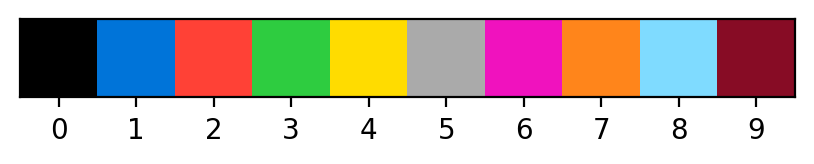

In [3]:
train1_path = '../input/arc-prize-2024/arc-agi_training_challenges.json'
train2_path = '../input/arc-prize-2024/arc-agi_training_solutions.json'

eval1_path = '../input/arc-prize-2024/arc-agi_evaluation_challenges.json'
eval2_path = '../input/arc-prize-2024/arc-agi_evaluation_solutions.json'

test_path = '../input/arc-prize-2024/arc-agi_test_challenges.json'
sample_path = '../input/arc-prize-2024/sample_submission.json'

# ......................................................................................................
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

norm = colors.Normalize(vmin=0, vmax=9)
color_list = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]

# ......................................................................................................
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

In [4]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def plot_pic(x):
    plt.imshow(np.array(x), cmap=cmap, norm=norm)
    plt.show()
    
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def plot_data(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()
    
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def plot_task(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in = np.array(t["input"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()  
    
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


![](https://cdn-images-1.medium.com/max/1000/1*7s_cV4TLZ1L31MJNj2Rk5w.png)

# <span style="color:darkred;">Solver 7 | Developed ARC 2020</span>

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [5]:
import signal
import psutil
import itertools
import subprocess
import base64, gzip
import networkx as nx
import multiprocessing
#::::::::::::::::::::::::::::::::::::::::::::::
from numpy import array
from pathlib import Path
from scipy import ndimage
from scipy.stats import mode
from tqdm.auto import trange
from functools import partial
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw
from xgboost import XGBClassifier
from itertools import combinations, product
from collections import defaultdict, Counter
from skimage.measure import label, regionprops
#::::::::::::::::::::::::::::::::::::::::::::::
from sklearn.tree import *
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from skimage.measure import label, regionprops
from sklearn.preprocessing import MinMaxScaler
#::::::::::::::::::::::::::::::::::::::::::::::
import warnings # suppress warnings
warnings.filterwarnings('ignore')
#::::::::::::::::::::::::::::::::::::::::::::::

<div>
    <img src='https://cdn-images-1.medium.com/max/1000/1*WWWVPaYg_eKA-8g8MKrOjw.png'> 
</div>

# <span style="color:darkred;">1 - Different Solvers</span>

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [6]:
################################################################################ 
# 40 Functions - Via Different Solvers
################################################################################ 1
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

################################################################################ 2
def get_objects(task):
    xs, ys = [], []
    for obj in task['train']:
        xs.append(np.array(obj['input']))
        ys.append(np.array(obj['output']))
    return xs, ys

################################################################################ 3
def find_sub(matrix, sub, ignore=None):
    positions = []
    mask = sub != ignore
    sub_ = sub[mask]
    for x in range(matrix.shape[0]-sub.shape[0]+1):
        for y in range(matrix.shape[1]-sub.shape[1]+1):
            if np.array_equal(matrix[x:x+sub.shape[0], y:y+sub.shape[1]][mask], sub_):
                positions.append((x,y,x+sub.shape[0],y+sub.shape[1]))
    return positions

################################################################################ 4
def check_subitem(task):
    for x, y in zip(*get_objects(task)):
        positions = find_sub(x, y)
        if len(positions) == 0:
            return False
    return True
            
################################################################################ 5
def check_samesize(task):
    for x,y in zip(*get_objects(task)):
        if x.shape != y.shape:
            return False
    return True

################################################################################ 6
def check_sub_mask(task):
    if check_samesize(task):
        return False
    for x,y in zip(*get_objects(task)):
        colors, counts = np.unique(x, return_counts=True)
        found = 0
        for c, area in zip(colors, counts):
            cxs, cys = np.where(x == c)
            xmin,ymin,xmax,ymax = min(cxs),min(cys),max(cxs)+1,max(cys)+1
            shape = (xmax-xmin, ymax-ymin)
            if shape == y.shape and area == np.prod(y.shape):
                found += 1
        if found != 1:
            return False
    return True

################################################################################ 7
def get_cells(x, cols, rows):
    if cols[0] != 0:
        cols = [-1]+cols
    if rows[0] != 0:
        rows = [-1]+rows
    if cols[-1] != x.shape[0]-1:
        cols.append(x.shape[0])
    if rows[-1] != x.shape[1]-1:
        rows.append(x.shape[1])
    cells = np.full((len(cols)-1, len(rows)-1), object)
    for i in range(len(cols)-1):
        for j in range(len(rows)-1):
            cells[i][j] = x[cols[i]+1:cols[i+1], rows[j]+1:rows[j+1]]
    return cells

################################################################################ 8
def get_grid(x):
    cols = defaultdict(list)
    rows = defaultdict(list)
    if x.shape[0] < 3 or x.shape[1] < 3:
        return -1, [], []
    for i in range(x.shape[0]):
        if len(np.unique(x[i])) == 1:
            cols[x[i,0]].append(i)
    for i in range(x.shape[1]):
        if len(np.unique(x[:,i])) == 1:
            rows[x[0,i]].append(i)
    for c in cols:
        if c in rows and all(np.diff(cols[c])>1) and all(np.diff(rows[c])>1):
            return c, cols[c], rows[c]
    return -1, [], []

################################################################################ 9
def check_grid(task):
    for x,y in zip(*get_objects(task)):
        color_of_grid, cols, rows = get_grid(x)
        if color_of_grid == -1:
            return False
    return True

################################################################################ 10
def mul_ratio(x, x_ratio):
    x_shape = (x.shape[0]*x_ratio[0], x.shape[1]*x_ratio[1])
    x_ = np.array([x[i//x_ratio[0]][j//x_ratio[1]] for i, j in np.ndindex(x_shape)]).reshape(x_shape)
    return x_

################################################################################ 11
def predict_transforms(xs, ys, test):
    fn = get_transform(xs, ys)
    if fn:
        return [fn(test)]
    ratio = get_ratio(xs, ys)
    if ratio:
        x_ratio, y_ratio = ratio
        xs_ = []
        ys_ = []
        for x, y in zip(xs, ys):
            x, y = mul_ratios(x, y, x_ratio, y_ratio)
            xs_.append(x)
            ys_.append(y)
        fn = get_transform(xs_, ys_)
        if fn:
            test = mul_ratio(test, x_ratio)
            return [fn(test)]
        fns = np.full(x_ratio, object)
        for i, j in np.ndindex(x_ratio):
            ys_ = []
            for y in ys:
                m1 = y.shape[0]//x_ratio[0]
                m2 = y.shape[1]//x_ratio[1]
                ys_.append(y[i*m1:(i+1)*m1,j*m2:(j+1)*m2])
            fn = get_transform(xs, ys_)
            if fn:
                fns[i,j] = fn
            else:
                return []
        return [np.concatenate([np.concatenate([fns[i,j](test) for i in range(x_ratio[0])], axis=0) for j in range(x_ratio[1])], axis=1)]
    return []

################################################################################ 12
def predict_grid_transforms(task, test):
    xs, ys = get_objects(task)
    xs = [grid_filter(x) for x in xs]
    return predict_transforms(xs, ys, grid_filter(test))

################################################################################ 13
def get_transform(xs, ys):
    for tranform in get_all_transforms():
        tranformed = True
        for x, y in zip(xs, ys):
            if tranform(x).shape != y.shape:
                tranformed = False
                break
            if not np.equal(tranform(x), y).all():
                tranformed = False
        if tranformed:
            return tranform
    return None

################################################################################ 14
def get_transforms(xs, ys):
    fn = get_transform(xs, ys)
    if fn:
        return fn
    ratio = get_ratio(xs, ys)
    if ratio:
        x_ratio, y_ratio = ratio
        xs_ = []
        ys_ = []
        for x, y in zip(xs, ys):
            x, y = mul_ratios(x, y, x_ratio, y_ratio)
            xs_.append(x)
            ys_.append(y)
        fn = get_transform(xs_, ys_)
        if fn:
            return fn
        fns = np.full(x_ratio, object)
        for i, j in np.ndindex(x_ratio):
            ys_ = []
            for y in ys:
                m1 = y.shape[0]//x_ratio[0]
                m2 = y.shape[1]//x_ratio[1]
                ys_.append(y[i*m1:(i+1)*m1,j*m2:(j+1)*m2])
            fn = get_transform(xs, ys_)
            if fn:
                fns[i,j] = fn
            else:
                return None
        return fns
    return None

################################################################################ 15
def check_grid_transforms(task):
    xs, ys = get_objects(task)
    xs = [grid_filter(x) for x in xs]
    return get_transforms(xs, ys) is not None

################################################################################ 16
def get_mode_color(ar):
    colors, counts = np.unique(ar, return_counts=True)
    return colors[np.argmax(counts)]

################################################################################ 17
def grid_filter(x):
    color_of_grid, cols, rows = get_grid(x)
    if color_of_grid == -1:
        return x
    cells = get_cells(x, cols, rows)
    return np.array([get_mode_color(cell) for cell in cells.reshape(-1)]).reshape(cells.shape)

################################################################################ 18
def mul_ratios(x, y, x_ratio, y_ratio):
    x_shape = (x.shape[0]*x_ratio[0], x.shape[1]*x_ratio[1])
    x_ = np.array([x[i//x_ratio[0]][j//x_ratio[1]] for i, j in np.ndindex(x_shape)]).reshape(x_shape)
    y_shape = (y.shape[0]*y_ratio[0], y.shape[1]*y_ratio[1])
    y_ = np.array([y[i//y_ratio[0]][j//y_ratio[1]] for i, j in np.ndindex(y_shape)]).reshape(y_shape)
    return x_, y_

################################################################################ 19
def get_ratio(xs, ys):
    x_ratio = []
    y_ratio = []
    for i in range(2):
        if   all(x.shape[i]%y.shape[i] == 0  for x, y in zip(xs, ys)):
            if len(set(x.shape[i]//y.shape[i] for x, y in zip(xs, ys))) == 1:
                x_ratio.append(1)
                y_ratio.append(xs[0].shape[i]//ys[0].shape[i])
        elif all(y.shape[i]%x.shape[i] == 0  for x, y in zip(xs, ys)):
            if len(set(y.shape[i]//x.shape[i] for x, y in zip(xs, ys))) == 1:
                x_ratio.append(ys[0].shape[i]//xs[0].shape[i])
                y_ratio.append(1)
    if len(x_ratio) != 2:
        return None
    return tuple(x_ratio), tuple(y_ratio)

################################################################################ 20
def check_sub_grid_2x(task):
    if check_samesize(task) or check_subitem(task):
        return False
    for x,y in zip(*get_objects(task)):
        color_of_grid, cols, rows = get_grid(x)
        if color_of_grid == -1:
            return False
        cells = grid_filter(x)
        if (cells.shape[0]*2 != y.shape[0] or cells.shape[1]*2 != y.shape[1]):
            return False
    return True

################################################################################ 21
def check_chess(task, input=False, output=True):
    xs, ys = get_objects(task)
    if input:
        for x in xs:
            if not has_chess(x) and not has_antichess(x):
                return False
    if output:
        for y in ys:
            if not has_chess(y) and not has_antichess(y):
                return False
    return True

################################################################################ 22
def has_chess(g):
    colors = np.unique(g)
    counts = len(colors)
    if counts < 2:
        return False
    indexes = np.zeros(counts, bool)
    for c in colors:
        pts = np.where(g == c)
        s = set([(x+y)%counts for x, y in zip(*pts)])
        if len(s) > 1:
            return False
        index = s.pop()
        if indexes[index]:
            return False
        indexes[index] = True
    return True

################################################################################ 23
def has_antichess(g):
    colors = np.unique(g)
    counts = len(colors)
    if counts < 2:
        return False
    indexes = np.zeros(counts, bool)
    for c in colors:
        pts = np.where(g == c)
        s = set([(g.shape[0]-x+y-1)%counts for x, y in zip(*pts)])
        if len(s) > 1:
            return False
        index = s.pop()
        if indexes[index]:
            return False
        indexes[index] = True
    return True

################################################################################ 24
def find_colors(g):
    colors = np.unique(g)
    counts = len(colors)
    for cnt in range(counts, 1, -1):
        q_colors = np.full(cnt, -1, int)
        for c in colors:
            pts = np.where(g == c)
            s = set([(x+y)%cnt for x, y in zip(*pts)])
            if len(s) > 1:
                continue
            index = s.pop()
            q_colors[index] = c
        
        if -1 not in q_colors:
            return q_colors
    return None

################################################################################ 25
def predict_chess(g):
    q_colors = find_colors(g)
    if q_colors is None:
        colors, counts = np.unique(g, return_counts=True)
        q_colors = colors[np.argsort(counts)][:2]
        
    results = []
    counts = len(q_colors)
    for i in range(counts):
        result = g.copy()
        for x, y in np.ndindex(g.shape):
            result[x,y] = q_colors[(x+y)%counts]
        results.append(result)
        q_colors = np.roll(q_colors, 1)
    return results

################################################################################ 26
def predict_transforms_grid_2x(task, test):
    xs, ys = get_objects(task)
    xs = [grid_filter(x) for x in xs]
    return predict_transforms_2x(xs, ys, grid_filter(test))

################################################################################ 27
def predict_transforms_2x(xs, ys, test):
    predictions = []
    transforms = [
        lambda x: np.rot90(x.T, k=1),
        lambda x: np.rot90(x.T, k=3),
        lambda x: np.rot90(x, k=2),
        lambda x: x,
    ]
    quads = [(1,3,2,0),(3,1,0,2),(2,0,1,3)] # 3 full symmetrical shapes
    for f1,f2,f3,f4 in quads:
        fns = np.array([[transforms[f1],transforms[f2]],[transforms[f3],transforms[f4]]])
        x_ = np.concatenate([np.concatenate([fns[i,j](test) for i in range(2)], axis=0) for j in range(2)], axis=1)
        predictions.append(x_)
    return predictions

################################################################################ 28
def has_repeating(g, ignore=0):
    size0b = int(.6 * g.shape[0])
    size1b = int(.6 * g.shape[1])
    t = np.full((g.shape[0]+2*size0b,g.shape[1]+2*size1b), -1)
    t[size0b:-size0b,size1b:-size1b] = g
    t[t==ignore] = -1
    for size0 in range(2, size0b+1):
        for size1 in range(2, size1b+1):
            for shift0 in range(size0):
                for shift1 in range(size1):
                    pattern = t[size0b+shift0:size0b+shift0+size0,size1b+shift1:size1b+shift1+size1].copy()
                    found = True
                    for d0 in range(size0b+shift0-size0, t.shape[0]-size0, size0):
                        for d1 in range(size1b+shift1-size1, t.shape[1]-size1, size1):
                            test = t[d0:d0+size0,d1:d1+size1]
                            mask = (test != -1) & (pattern != -1)
                            if np.array_equal(test[mask], pattern[mask]):
                                ind = test != -1
                                pattern[ind] = test[ind]
                            else:
                                found = False
                                break
                    if found:
                        return shift0, shift1, pattern
    return None

################################################################################ 29
def check_repeating(task, has_complete=False):
    patterns = []
    for x, y in zip(*get_objects(task)):
        if len(np.unique(x)) < 3 or not has_repeating(y,-1):
            return False
        result = None
        for c in np.unique(x):
            # if c not in np.unique(y):
            result = has_repeating(x,c)
            if result:
                sh0,sh1,pattern = result
                pattern[pattern == -1] = c
                if has_complete:
                    pred = np.tile(pattern, (x.shape[0]//pattern.shape[0]+2, x.shape[1]//pattern.shape[1]+2))
                    pred1 = pred[sh0:sh0+x.shape[0],sh1:sh1+x.shape[1]]
                    pred2 = pred[sh0+1:sh0+1+x.shape[0],sh1:sh1+x.shape[1]]
                    pred3 = pred[sh0:sh0+x.shape[0],sh1+1:sh1+1+x.shape[1]]
                    if np.array_equal(pred1, y) or np.array_equal(pred2, y) or np.array_equal(pred3, y):
                        break
                    result = None
                else:
                    break
        if not result:
            return False
    return True

################################################################################ 30
def predict_repeating(x):
    for c in np.unique(x):
        result = has_repeating(x, c)
        if result:
            sh0,sh1,pattern = result
            pattern[pattern == -1] = c
            pred = np.tile(pattern, (x.shape[0]//pattern.shape[0]+2, x.shape[1]//pattern.shape[1]+2))
            pred1 = pred[sh0:sh0+x.shape[0],sh1:sh1+x.shape[1]]
            pred2 = pred[sh0+1:sh0+1+x.shape[0],sh1:sh1+x.shape[1]]
            pred3 = pred[sh0:sh0+x.shape[0],sh1+1:sh1+1+x.shape[1]]
            return [pred1,pred2,pred3]
    return []

################################################################################ 31
def predict_repeating_mask(x):
    predictions = predict_repeating(x)
    if len(predictions) > 0:
        rows, cols = np.where(predictions[0] != x)
        return [predictions[0][min(rows):max(rows)+1,min(cols):max(cols)+1]]
    return []

################################################################################ 32
def trim_matrix(x):
    if len(np.unique(x)) == 1:
        return x
    for c in np.unique(x):
        xs,ys = np.where(x!=c)
        xmin,ymin,xmax,ymax = min(xs),min(ys),max(xs)+1,max(ys)+1
        if xmin > 0 or ymin > 0 or xmax < x.shape[0] or ymax < x.shape[1]:
            return x[xmin:xmax,ymin:ymax]
    return x

################################################################################ 33
def trim_matrix_box(g, mask=None):
    if mask is None:
        mask = np.unique(g)
    if len(np.unique(g)) == 1:
        return None
    for c in mask:
        xs,ys = np.where(g!=c)
        xmin,ymin,xmax,ymax = min(xs),min(ys),max(xs)+1,max(ys)+1
        if xmin > 0 or ymin > 0 or xmax < g.shape[0] or ymax < g.shape[1]:
            return (xmin,ymin,xmax,ymax)
    return None

################################################################################ 34
def has_tiles(g, ignore=0):
    for size0b, size1b in [(g.shape[0], int(0.6*g.shape[1])), (int(0.6*g.shape[0]), g.shape[1])]:
        t = np.full((g.shape[0]+size0b, g.shape[1]+size1b), -1)
        t[:-size0b,:-size1b] = g
        t[t==ignore] = -1
        box_trim = trim_matrix_box(g,[ignore])
        min_size0 = 1
        min_size1 = 1
        if box_trim is not None and ignore != -1:
            xmin,ymin,xmax,ymax = box_trim
            t[xmin:xmax,ymin:ymax] = g[xmin:xmax,ymin:ymax]
            min_size0 = xmax-xmin
            min_size1 = ymax-ymin
        for size0 in range(min_size0, size0b+1):
            for size1 in range(min_size1, size1b+1):
                pattern = t[:size0,:size1].copy()
                found = True
                for d0 in range(0, t.shape[0]-size0, size0):
                    for d1 in range(0, t.shape[1]-size1, size1):
                        test = t[d0:d0+size0,d1:d1+size1]
                        mask = (test != -1) & (pattern != -1)
                        if np.array_equal(test[mask], pattern[mask]):
                            ind = test != -1
                            pattern[ind] = test[ind]
                        else:
                            found = False
                            break
                if found:
                    return pattern
    return None

################################################################################ 35
def roll_color(g):
    from_values = np.unique(g)
    to_values = np.roll(from_values, 1)

    sort_idx = np.argsort(from_values)
    idx = np.searchsorted(from_values, g, sorter = sort_idx)
    return to_values[sort_idx][idx]

################################################################################ 36
def get_all_transforms():
    return [
        lambda x: roll_color(x),
        lambda x: np.roll(x, -1, axis=0),
        lambda x: np.roll(x,  1, axis=0),
        lambda x: np.roll(x, -1, axis=1),
        lambda x: np.roll(x,  1, axis=1),
        lambda x: np.rot90(x.T, k=1),
        lambda x: np.rot90(x.T, k=2),
        lambda x: np.rot90(x.T, k=3),
        lambda x: np.rot90(x.T, k=4),
        lambda x: np.rot90(x, k=1),
        lambda x: np.rot90(x, k=2),
        lambda x: np.rot90(x, k=3),
        lambda x: x,
    ]

################################################################################ 37
def has_tiles_shape(g, shape, ignore=0):
    for size0b, size1b in [(g.shape[0], int(0.6*g.shape[1])), (int(0.6*g.shape[0]), g.shape[1])]:
        t = np.full((g.shape[0]+size0b, g.shape[1]+size1b), -1)
        t[:-size0b,:-size1b] = g
        t[t==ignore] = -1
        box_trim = trim_matrix_box(g,[ignore])
        min_size0 = 1
        min_size1 = 1
        if box_trim is not None and ignore != -1:
            xmin,ymin,xmax,ymax = box_trim
            t[xmin:xmax,ymin:ymax] = g[xmin:xmax,ymin:ymax]
            min_size0 = xmax-xmin
            min_size1 = ymax-ymin
        size0 = shape[0]
        size1 = shape[1]
        pattern = t[:size0,:size1].copy()
        found = True
        for d0 in range(0, t.shape[0]-size0, size0):
            for d1 in range(0, t.shape[1]-size1, size1):
                test = t[d0:d0+size0,d1:d1+size1]
                mask = (test != -1) & (pattern != -1)
                if np.array_equal(test[mask], pattern[mask]):
                    ind = test != -1
                    pattern[ind] = test[ind]
                else:
                    found = False
                    break
        if found:
            return pattern
    return None

################################################################################ 38
def check_tiles_shape(task, has_complete=0): 
    patterns = []
    for x, y in zip(*get_objects(task)):
        o_pattern = has_tiles(y,-1)
        if len(np.unique(x)) < 2 or o_pattern is None:
            return False
        found = False
        for c in [-1, *np.unique(x)]:
            pattern = has_tiles_shape(x, o_pattern.shape, c)
            if pattern is not None:
                pattern[pattern == -1] = c
                if has_complete:
                    for transform in get_all_transforms():
                        transformed_pattern = transform(pattern)
                        pred = np.tile(transformed_pattern, (x.shape[0]//transformed_pattern.shape[0]+2, x.shape[1]//transformed_pattern.shape[1]+2))
                        pred = pred[:x.shape[0],:x.shape[1]]
                        if np.array_equal(pred, y):
                            found = True
                            patterns.append(pattern)
                            break
                else:
                    found = True
                    patterns.append(pattern)
        if not found:
            return False
    return True

################################################################################ 39
def predict_tiles_shape(task, test_input):
    has_transforms = set()
    has_shapes = set()
    for x, y in zip(*get_objects(task)):
        o_pattern = has_tiles(y,-1)
        if len(np.unique(x)) < 2 or o_pattern is None:
            return []
        found = False
        for c in [-1, *np.unique(x)]:
            pattern = has_tiles_shape(x, o_pattern.shape, c)
            if pattern is not None:
                pattern[pattern == -1] = c
                for transform in get_all_transforms():
                    transformed_pattern = transform(pattern)
                    pred = np.tile(transformed_pattern, (x.shape[0]//transformed_pattern.shape[0]+2, x.shape[1]//transformed_pattern.shape[1]+2))
                    pred = pred[:x.shape[0],:x.shape[1]]
                    if np.array_equal(pred, y):
                        found = True
                        has_transforms.add(transform)
                        has_shapes.add(o_pattern.shape)
                        break
        if not found:
            return []
     
    preds = []
    for c in np.unique(test_input):
        for shape in has_shapes:
            pattern = has_tiles_shape(test_input, shape, c)
            if pattern is None:
                continue
            pattern[pattern == -1] = c

            pred = np.tile(pattern, (test_input.shape[0]//pattern.shape[0]+2, test_input.shape[1]//pattern.shape[1]+2))
            for transform in has_transforms:
                transformed_pattern = transform(pattern)
                pred = np.tile(transformed_pattern, (test_input.shape[0]//transformed_pattern.shape[0]+2, test_input.shape[1]//transformed_pattern.shape[1]+2))
                pred = pred[:test_input.shape[0],:test_input.shape[1]]
                preds.append(pred)
    return preds

################################################################################ 40



<div>
    <img src='https://cdn-images-1.medium.com/max/1000/1*UurBdaImPTYbKVk2POYpJQ.png'> 
</div>

# <span style="color:darkred;">2 - Sklearn tree</span>

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [7]:
%%writefile main.cpp
#include <iostream>
#include <fstream>
#include <array>
#include <algorithm>
#include <vector>
#include <random>
#include <sstream>
#include <cassert>

using namespace std;
typedef float feature_type;
typedef vector<vector<int>> grid;
struct box {
    int xmin = 999, ymin = 999, xmax = -999, ymax = -999;
    double width()  const {return xmin != 999 && xmax != -999 ? xmax - xmin : 0.0;}
    double height() const {return ymin != 999 && ymax != -999 ? ymax - ymin : 0.0;}
    double area() const {return width()*height();}
    double perimeter() const {return 2*(width()+height());}
    static box grid(const grid& g) {return box{0, 0, int(g.size()), int(g[0].size())};}
    box reshape(int t) const {return box{xmin-t, ymin-t, xmax+t, ymax+t};}
    bool has_box(box b) const {
        return area() > 0 && b.area() > 0 && xmin <= b.xmin && xmax >= b.xmax && ymin <= b.ymin && ymax >= b.ymax;
    }
    bool has_intersection(box b) const {
        return area() > 0 && b.area() > 0 && ymin < b.ymax && ymax > b.ymin && xmin < b.xmax && xmax > b.xmin;
    }
    double iou(box b) const {
        double xmaxmin = max(xmin, b.xmin);
        double ymaxmin = max(ymin, b.ymin);
        double xminmax = min(xmax, b.xmax);
        double yminmax = min(ymax, b.ymax);
        
        bool has_inter = has_intersection(b);
        double inter_area = has_inter ? (xminmax - xmaxmin) * (yminmax - ymaxmin) : 0.0;
        double whole_area = area() + b.area() - inter_area;
        return inter_area / whole_area;
    }
};
vector<string> split(istream& ss, char sep = ' ') {
    vector<string> output;
    string line;
    for (;getline(ss, line, sep);) {
        output.emplace_back(line);
    }
    return output;
}
vector<string> split(string input, char sep = ' ') {
    istringstream ss(input);
    return split(ss, sep);
}
array<int, 10> count(const grid& g, box b) {
    array<int, 10> result;
    result.fill(0);
    for (auto x = b.xmin; x < b.xmax; ++x)
        for (auto y = b.ymin; y < b.ymax; ++y)
            ++result[g[x][y]];
    return result;
}
array<int, 10> count(const grid& g) {
    return count(g, box::grid(g));
}
bool has_vertical_symmetry(const grid& g, box b) {
    for (int x = b.xmin; x<b.xmax; ++x)
        for (int dy = 0; dy < (b.ymax-b.ymin)/2; ++dy) {
            if (g[x][b.ymin+dy] != g[x][b.ymax-dy-1])
                return false;
        }
    return true;
}
bool has_horizontal_symmetry(const grid& g, box b) {
    for (int y = b.ymin; y < b.ymax; ++y)
        for (int dx = 0; dx < (b.xmax-b.xmin)/2; ++dx) {
            if (g[b.xmin+dx][y] != g[b.xmax-dx-1][y])
                return false;
        }
    return true;
}
bool has_frame(const grid& g, box b, bool unique_frame = false) {
    vector<int> cs;
    int mx = int(g.size()), my = int(g[0].size());
    int xmin_ = max(0, b.xmin), xmax_ = min(b.xmax, mx);
    int ymin_ = max(0, b.ymin), ymax_ = min(b.ymax, my);
    if (b.xmin == xmin_)
        for (int y = ymin_; y < ymax_; ++y)
            cs.emplace_back(g[b.xmin][y]);
    if (b.xmax == xmax_)
        for (int y = ymin_; y < ymax_; ++y)
            cs.emplace_back(g[b.xmax-1][y]);
    if (b.ymin == ymin_)
        for (int x = xmin_; x < xmax_; ++x)
            cs.emplace_back(g[x][b.ymin]);
    if (b.ymax == ymax_)
        for (int x = xmin_; x < xmax_; ++x)
            cs.emplace_back(g[x][b.ymax-1]);
    for (int i = 1; i < cs.size(); ++i)
        if (cs[i] != cs[i-1])
            return false;
    if (unique_frame && !cs.empty())
        for (int x = max(0, b.xmin+1); x < min(b.xmax-1, mx); ++x)
            for (int y = max(0, b.ymin+1); y < min(b.ymax-1, my); ++y)
                if (g[x][y] == cs[0])
                    return false;
    return true;
}
int cnt_strime(const grid& g, box b) {
    int n = 0;
    int mx = int(g.size()), my = int(g[0].size());
    if (b.xmin >= b.xmax || b.ymin >= b.ymax)
        return n;
    int xmin_ = max(0, b.xmin), xmax_ = min(b.xmax, mx);
    int ymin_ = max(0, b.ymin), ymax_ = min(b.ymax, my);
    if (b.xmin == xmin_ && ymax_ - ymin_ > 1) {
        ++n;
        for (int y = ymin_+1; y < ymax_; ++y)
            if (g[b.xmin][y-1] != g[b.xmin][y]) {
                --n;
                break;
            }
    }
    if (b.xmax == xmax_ && ymax_ - ymin_ > 1) {
        ++n;
        for (int y = ymin_+1; y < ymax_; ++y)
            if (g[b.xmax-1][y-1] != g[b.xmax-1][y]) {
                --n;
                break;
            }
    }
    if (b.ymin == ymin_ && xmax_ - xmin_ > 1) {
        ++n;
        for (int x = xmin_+1; x < xmax_; ++x)
            if (g[x-1][b.ymin] != g[x][b.ymin]) {
                --n;
                break;
            }
    }
    if (b.ymax == ymax_ && xmax_ - xmin_ > 1) {
        ++n;
        for (int x = xmin_+1; x < xmax_; ++x)
            if (g[x-1][b.ymax-1] != g[x][b.ymax-1]) {
                --n;
                break;
            }
    }
    return n;
}
bool is_same_box(const grid& g, box l, box r) {
    for (int dx = 0; dx < l.width(); ++dx)
        for (int dy = 0; dy < l.height(); ++dy)
            if (g[l.xmin+dx][l.ymin+dy] != g[r.xmin+dx][r.ymin+dy])
                return false;
    return true;
}
int cnt_same_boxes(const grid& g, box b) {
    int n = 0;
    int width = b.width();
    int height = b.height();
    for (int x = 0; x < g.size() - width; ++x)
        for (int y = 0; y < g[0].size() - height; ++y) {
            if (is_same_box(g, b, {x, y, width, height}))
                ++n;
        }
    return n;
}
array<box, 10> get_boxes_of_colors(const grid& g) {
    array<box, 10> boxes;
    for (int x = 0; x < g.size(); ++x)
        for (int y = 0; y < g[0].size(); ++y) {
            int c = g[x][y];
            boxes[c].xmin = min(boxes[c].xmin, x);
            boxes[c].ymin = min(boxes[c].ymin, y);
            boxes[c].xmax = max(boxes[c].xmax, x+1);
            boxes[c].ymax = max(boxes[c].ymax, y+1);
        }
    return boxes;
}
array<box, 10> get_boxes_of_colors_inverse(const grid& g) {
    array<box, 10> boxes;
    for (int x = 0; x < g.size(); ++x)
        for (int y = 0; y < g[0].size(); ++y) {
            for (int c = 0; c < 10; ++c) if (c != g[x][y]) {
                boxes[c].xmin = min(boxes[c].xmin, x);
                boxes[c].ymin = min(boxes[c].ymin, y);
                boxes[c].xmax = max(boxes[c].xmax, x+1);
                boxes[c].ymax = max(boxes[c].ymax, y+1);
            }
        }
    return boxes;
}
void boxes_features(vector<feature_type>& row, box l, box r) {
//    row.emplace_back(l.area()/r.area());
//    row.emplace_back(l.iou(r));
    row.emplace_back(l.iou(r) > 0.99);
}
vector<int> get_colors(const grid& g, const array<box, 10>& boxes_of_colors, box bx) {
    vector<int> colors;
    auto cnt_colors = count(g, bx);
    auto all_colors = count(g);
    int used_color = -1;
    int used_color2 = -1;
    for (int  c = 9; c >= 0; --c) {
        if (used_color != -1 && cnt_colors[c] > 0) {
            used_color2 = c;
            break;
        }
        if (used_color == -1 && cnt_colors[c] > 0) {
            used_color = c;
        }
    }
    int gr_percent = used_color;
    int gr_area_not_black = used_color;
    int gr_area = used_color;
    int ls_area = used_color;
    int gr_iou = used_color;
    for (int c = 0; c < 10; ++c) {
//        colors.emplace_back(c);
        if (cnt_colors[gr_percent] / float(all_colors[gr_percent]) < cnt_colors[c] / float(all_colors[c]))
            gr_percent = c;
        if (boxes_of_colors[gr_area].area() < boxes_of_colors[c].area())
            gr_area = c;
        if (c != 0 && boxes_of_colors[gr_area_not_black].area() < boxes_of_colors[c].area())
            gr_area_not_black = c;
        if (boxes_of_colors[c].area() > 0 && boxes_of_colors[ls_area].area() > boxes_of_colors[c].area())
            ls_area = c;
        if (boxes_of_colors[gr_iou].iou(bx) < boxes_of_colors[c].iou(bx))
            gr_iou = c;
    }
    int gr_area2 = gr_area == used_color ? used_color2 : used_color;
    for (int c = 0; c < 10; ++c) {
        if (c != gr_area && boxes_of_colors[gr_area2].area() < boxes_of_colors[c].area())
            gr_area2 = c;
    }
    colors.emplace_back(gr_percent);        // 0
    colors.emplace_back(gr_area_not_black); // 1
    colors.emplace_back(gr_area);           // 2
    colors.emplace_back(gr_area2);          // 3
    colors.emplace_back(ls_area);           // 4
    colors.emplace_back(gr_iou);            // 5
    
    return colors;
}
vector<feature_type> make_feature(const grid& g, const array<box, 10>& boxes_of_colors, const box bx) {
    vector<feature_type> row;
    row.emplace_back(bx.xmin);
    row.emplace_back(bx.ymin);
    row.emplace_back(bx.xmax);
    row.emplace_back(bx.ymax);
    
    auto ibx = box::grid(g);
    
    int has_boxes = 0;
    int in_boxes = 0;
    auto boxes_of_colors_inverse = get_boxes_of_colors_inverse(g);
    for (auto c : get_colors(g, boxes_of_colors, bx)) {
        boxes_features(row, bx, boxes_of_colors[c]);
        boxes_features(row, bx, boxes_of_colors_inverse[c]);
        boxes_features(row, bx.reshape(1), boxes_of_colors[c]);
        boxes_features(row, bx.reshape(1), boxes_of_colors_inverse[c]);
    }
    auto cnt_colors = count(g, bx);
    int ucnt_colors = 0;
    for (int c = 0; c < 10; ++c) {
        ucnt_colors += cnt_colors[c] > 0;
        has_boxes += bx.has_box(boxes_of_colors[c]);
        in_boxes += boxes_of_colors[c].has_box(bx);
    }
    
    boxes_features(row, bx, ibx);
    bool has_frame_ = has_frame(g, bx);
    bool has_frame_1 = has_frame(g, bx.reshape(1));
//    bool has_frame_m1 = has_frame(g, bx.reshape(-1));
    int cnt_trime_ = cnt_strime(g, bx);
    row.emplace_back(cnt_same_boxes(g, bx));
    row.emplace_back(has_frame_ ? cnt_same_boxes(g, bx) : 0);
    row.emplace_back(cnt_trime_ == 0 ? cnt_same_boxes(g, bx) : 0);
    row.emplace_back(has_vertical_symmetry(g, bx));
    row.emplace_back(has_horizontal_symmetry(g, bx));

    row.emplace_back(ucnt_colors);
    row.emplace_back(has_boxes);
    row.emplace_back(in_boxes);
    row.emplace_back(has_frame(g, bx, true));
    row.emplace_back(has_frame(g, bx.reshape(1), true));
    row.emplace_back(has_frame_);
    row.emplace_back(has_frame_1);
//    row.emplace_back(has_frame_m1);
    row.emplace_back(has_frame_1 || has_frame_);
    row.emplace_back(has_frame_1 && has_frame_);
    row.emplace_back(has_frame_1 == has_frame_);
    row.emplace_back(bx.width());
    row.emplace_back(bx.height());
    row.emplace_back(bx.area());
    row.emplace_back(cnt_trime_);
    row.emplace_back(cnt_strime(g, bx.reshape(1)));
    row.emplace_back(cnt_strime(g, bx.reshape(-1)));
    
//    row.emplace_back(perimeter);
    return row;
}
string get_columns() {
    stringstream ss;
    ss << "xmin" << "\t";
    ss << "ymin" << "\t";
    ss << "xmax" << "\t";
    ss << "ymax" << "\t";
    for (int i = 0; i < 7; ++i) {
        for (int j = 0; j < 1 + 3*(i < 6); ++j) {
//            ss << "[" << i << j << "] div_areas" << "\t";
//            ss << "[" << i << j << "] iou" << "\t";
            ss << "[" << i << j << "] iou_1" << "\t";
        }
    }
    ss << "cnt_same_boxes" << "\t";
    ss << "cnt_same_boxes_w_fr" << "\t";
    ss << "cnt_same_boxes_wo_tr" << "\t";
    ss << "has_vertical_symmetry" << "\t";
    ss << "has_horizontal_symmetry" << "\t";
    
    ss << "ucnt_colors" << "\t";
    
    ss << "has_boxes" << "\t";
    ss << "in_boxes" << "\t";
    ss << "has_uframe" << "\t";
    ss << "has_uframe_1" << "\t";
    ss << "has_frame" << "\t";
    ss << "has_frame_1" << "\t";
//    ss << "has_frame_1m" << "\t";
    ss << "has_frame_or" << "\t";
    ss << "has_frame_and" << "\t";
    ss << "has_frame_eq" << "\t";
    ss << "width" << "\t";
    ss << "height" << "\t";
    ss << "area" << "\t";
    ss << "cnt_strim" << "\t";
    ss << "cnt_strim_1" << "\t";
    ss << "cnt_strim_m1";
//    ss << "perimeter";
    return ss.str();
}
void make_features(const grid& g, ostream& out) {
    auto boxes_of_colors = get_boxes_of_colors(g);
    int n = 0;
    box l = box::grid(g);
    for (int xmin = 0; xmin < g.size(); ++xmin)
        for (int ymin = 0; ymin < g[0].size(); ++ymin)
            for (int xmax = xmin+1; xmax < g.size()+1; ++xmax)
                for (int ymax = ymin+1; ymax < g[0].size()+1; ++ymax) {
                    box r = {xmin, ymin, xmax, ymax};
                    if (r.area() == l.area()) // || r.area() == 1) || (!has_frame(g, r) && !has_frame(g, r.reshape(1)))
                        continue;
                    auto row = make_feature(g, boxes_of_colors, r);
                    out.write((char*)&row[0], row.size() * sizeof(row[0]));
                    n += 1;
                }
    cout << "rows: " << n << endl;
}
inline bool exists(const std::string& name) {
    ifstream f(name.c_str());
    return f.good();
}
int main() {
    string dir = "jupyter/arc/";
    if (!exists(dir+"ex.txt"))
        dir = "./";
    vector<grid> inputs;
    ifstream fin(dir + "ex.txt");
    ofstream fout(dir + "features.bin", ios::out | ios::binary);
    ofstream fcolumns(dir + "features.tsv");
    fcolumns << get_columns();
    for (auto input: split(fin, ' ')) {
        vector<vector<int>> g;
        for (auto line : split(input, '|')) {
            vector<int> row;
            for (char& c : line)
                row.emplace_back(c-'0');
            g.emplace_back(row);
        }
        inputs.emplace_back(g);
    }
    cout << "inputs: " << inputs.size() << endl;
    auto features = make_feature({{1}}, get_boxes_of_colors({{1}}),{0, 0, 1, 1});
    cout << "features: " << features.size() << endl;
    cout << "columns: " << split(get_columns(), '\t').size() << endl;
    assert(features.size() == split(get_columns(), '\t').size());
    for (auto input : inputs) {
        cout << "shape: " << input.size() << "x" << input[0].size() << endl;
        make_features(input, fout);
    }
    return 0;
}

Writing main.cpp


In [8]:
!g++ -pthread -lpthread -O3 -std=c++17 -o main main.cpp
!./main

inputs: 0
features: 50
columns: 50


In [9]:
################################################################################ 
# 8 Functions - Via Tree
################################################################################ 1
def plot_objects(objects, titles=None):
    if titles is None:
        titles = np.full(len(objects), '')
    cmap = matplotlib.colors.ListedColormap(['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = matplotlib.colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, len(objects), figsize=(30,3), gridspec_kw = {'wspace':0.02, 'hspace':0.02}, squeeze=False)

    for i, (obj, title) in enumerate(zip(objects, titles)):
        obj = np.array(obj)
        axs[0,i].grid(True,which='both',color='lightgrey', linewidth=0.5)  
#         axs[i].axis('off')
        shape = ' '.join(map(str, obj.shape))
        axs[0,i].set_title(f"{title} {shape}")
        axs[0,i].set_yticks([x-0.5 for x in range(1+len(obj))])
        axs[0,i].set_xticks([x-0.5 for x in range(1+len(obj[0]))])
        axs[0,i].set_yticklabels([])     
        axs[0,i].set_xticklabels([])
        axs[0,i].imshow(obj, cmap=cmap, norm=norm)
    plt.show()

################################################################################ 2
def find_sub(matrix, sub):
    positions = []
    for x in range(matrix.shape[0]-sub.shape[0]+1):
        for y in range(matrix.shape[1]-sub.shape[1]+1):
            if np.equal(matrix[x:x+sub.shape[0], y:y+sub.shape[1]], sub).all():
                positions.append((x,y,x+sub.shape[0],y+sub.shape[1]))
    return positions

################################################################################ 3
def check_subitem(task):
    for key in ['train', 'test']:
        for obj in task[key]:
            if 'output' in obj:
                x = np.array(obj['input'])
                y = np.array(obj['output'])
                if len(find_sub(x, y)) == 0:
                    return False
    return True 

################################################################################ 4
def get_objects(task, has_train=True, has_test=False):
    xs, ys = [], []
    names = []
    if has_train:
        names.append('train')
    if has_test:
        names.append('test')
    for key in names:
        for obj in task[key]:
            xs.append(np.array(obj['input']))
            if 'output' not in obj:
                continue
            ys.append(np.array(obj['output']))
    return xs, ys

################################################################################ 5
def make_features(x, has_frame=False):
    def short_flattener(pred):
        str_pred = str([row for row in pred])
        str_pred = str_pred.replace(', ', '')
        str_pred = str_pred.replace('[[', '')
        str_pred = str_pred.replace('][', '|')
        str_pred = str_pred.replace(']]', '')
        return str_pred
    with open("ex.txt", "w") as f:
        f.write(short_flattener(x.tolist()))
    !./main > /dev/null
    columns = pd.read_csv('features.tsv', sep='\t').columns
    columns = ["".join (c if c.isalnum() else "_" for c in str(col)) for col in columns]
    df = pd.DataFrame(np.fromfile('features.bin', dtype = [(col, '<f4') for col in columns]))
    
    df['rps4'] = False
    df['rps8'] = False
    labels = label(x, background=-1, connectivity=2)+2
    rps = regionprops(labels, cache=False)
    for r in rps:
        xmin, ymin, xmax, ymax = r.bbox
        df.loc[(df['xmin']==xmin)&(df['ymin']==ymin)&(df['xmax']==xmax)&(df['ymax']==ymax), 'rps8'] = True
    labels = label(x, background=-1, connectivity=1)+2
    rps = regionprops(labels, cache=False)
    for r in rps:
        xmin, ymin, xmax, ymax = r.bbox
        df.loc[(df['xmin']==xmin)&(df['ymin']==ymin)&(df['xmax']==xmax)&(df['ymax']==ymax), 'rps4'] = True
    
    if has_frame:
        df = df[(df['has_frame']==1)|(df['has_frame_1']==1)]
    for col in ['cnt_same_boxes', 'cnt_same_boxes_w_fr', 'cnt_same_boxes_wo_tr', 'ucnt_colors']:
        df[f"{col}_rank"]  = df[col].rank(method="dense")
        df[f"{col}_rank_"] = df[col].rank(method="dense", ascending=False)
    for col in df.columns:
        if 'iou' in col or col in ['has_frame', 'has_frame_1']:
            df[f"{col}_rank"]  = df.groupby([col])['area'].rank(method="dense")
            df[f"{col}_rank_"] = df.groupby([col])['area'].rank(method="dense", ascending=False)
    return df

################################################################################ 6
def decision_tree(train, test, test_input):
    y = train.pop('label')
    model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=4372).fit(train.drop(['xmin','ymin','xmax','ymax'], axis=1), y)
    preds = model.predict_proba(test.drop(['xmin','ymin','xmax','ymax'], axis=1))[:,1]
    
    indexes = np.argsort(preds)[::-1]
    objects,objs,titles = [],[],[]
    for score, (xmin,ymin,xmax,ymax) in zip(preds[indexes], test[['xmin','ymin','xmax','ymax']].astype(int).values[indexes]):
        obj = test_input[xmin:xmax,ymin:ymax]
        str_obj = flattener(obj.tolist())
        if str_obj not in objects:
            objects.append(str_obj)
            objs.append(obj)
            titles.append(str(np.round(score, 4)))
        if len(objects) > 10:
            break
    plot_objects(objs, titles) 
    return objects

################################################################################ 7
def tree1(train, test, test_input):
    y = train.pop('label')
    model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=4372).fit(train.drop(['xmin','ymin','xmax','ymax'], axis=1), y)
    preds = model.predict_proba(test.drop(['xmin','ymin','xmax','ymax'], axis=1))[:,1]
    
    indexes = np.argsort(preds)[::-1]
    objects,objs,titles = [],[],[]
    for score, (xmin,ymin,xmax,ymax) in zip(preds[indexes], test[['xmin','ymin','xmax','ymax']].astype(int).values[indexes]):
        obj = test_input[xmin:xmax,ymin:ymax]
        str_obj = flattener(obj.tolist())
        if str_obj not in objects:
            objects.append(str_obj)
            objs.append(obj)
            titles.append(str(np.round(score, 4)))
        if len(objects) > 1:
            break
    #plot_objects(objs, titles) 
    return objs

################################################################################ 8
def format_features(task):
    train = []
    for ttid, obj in enumerate(task['train']):
        x = np.array(obj['input'])
        y = np.array(obj['output'])
        df = make_features(x)
        df['label'] = False
#         df['tid'] = ttid
        positions = find_sub(x, y)
        for xmin,ymin,xmax,ymax in positions:
            df.loc[(df['xmin']==xmin)&(df['ymin']==ymin)&(df['xmax']==xmax)&(df['ymax']==ymax), 'label'] = True
        train.append(df)
    train = pd.concat(train).reset_index(drop=True)
    return train


<div>
    <img src='https://cdn-images-1.medium.com/max/1000/1*x8hLqHg5rgGJv1kZHpIGjg.png'> 
</div>

# <span style="color:darkred;">3 - Symmetry Repairing</span>

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [10]:
################################################################################ 
# 31 Functions - Via Symmetry Repairing
################################################################################ 1
def Translation(x):
    n = len(x)
    k = len(x[0])
    Best_r = n
    Best_s = k
    x0 = np.array(x, dtype = int)
    for r in range(1,n):
        if x0[:n-r,:].tolist() == x0[r:,:].tolist():
            Best_r = r
            break
    for s in range(1,k):
        if x0[:,:k-s].tolist() == x0[:,s:].tolist():
            Best_s = s
            break
    if (Best_r, Best_s) == (n,k):
        return []
    r = Best_r
    s = Best_s
    E = {}
    for i in range(n):
        for j in range(k):
            u = i%r
            v = j%s
            p = (u,v)
            if p not in E:
                E[p] = [(i,j)]
            else:
                E[p] = E[p]+[(i,j)]
    Ans = []
    for p in E:
        item = E[p]
        if len(item) > 1:
            Ans.append(item)
    return Ans
                      
################################################################################ 2
def Translation1D(x):
    n = len(x)
    k = len(x[0])
 
    PossibleS = []
    
    for r in range(-n+1,n):
        for s in range(-k+1,k): 
            if s == 0 and r == 0:
                continue
            Equiv_Colors = {}
            possible = True
            for i in range(n):
                if possible == False:
                    break
                for j in range(k):
                    u = i*s-j*r 
                    v = (i*r+j*s+100*(r*r+s*s))%(r*r+s*s)
                    color = 0+  x[i][j]
                    if (u,v) not in Equiv_Colors:
                        Equiv_Colors[(u,v)] = color
                    elif color != Equiv_Colors[(u,v)]:
                        possible = False
                        break
            if possible:
                PossibleS.append((r,s))
                
    if len(PossibleS) == 0:
        return []
   
    Scores = []
    for p in PossibleS:
        r, s = p
        Scores.append((abs(r)+abs(s),p))
    Scores.sort()
    Best_r, Best_s = Scores[0][1]
    r = Best_r
    s = Best_s
    E = {}
    for i in range(n):
        for j in range(k):
            u = i*s-j*r
            v = (i*r+j*s+100*(r*r+s*s))%(r*r+s*s)
            p = (u,v)
            if p not in E:
                E[p] = [(i,j)]
            else:
                E[p] = E[p]+[(i,j)]
    Ans = []
    for p in E:
        item = E[p]
        if len(item) > 1:
            Ans.append(item)
    return Ans

################################################################################ 3   
def HorSym(x): 
    n = len(x)
    k = len(x[0])
    PossibleR = []
    
    for r in range(1,2*n-2): 
        possible = True
        for i in range(n):
            for j in range(k):
                i1 = r-i
                if i1 <0 or i1>=n:
                    continue
                color1 = x[i][j]
                color2 = x[i1][j]
                if color1 != color2:
                    possible = False
                    break
        if possible:
            PossibleR.append(r)
    if len(PossibleR) == 0:
        return []
    
    Scores = []
    for r in PossibleR:
        Scores.append((abs(r-n+1),r))
    Scores.sort()
    Best_r = Scores[0][1]
    r = Best_r
    Ans = []
    for i in range(n):
        for j in range(k):
            i1 = r-i
            if i1 <0 or i1 >= n:
                continue
            a = (i,j)
            b = (i1,j)
            i
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans

################################################################################ 4
def VertSym(x):
    n = len(x)
    k = len(x[0])
    PossibleS = []
 
    for s in range(1,2*k-2): 
        possible = True
        for i in range(n):
            for j in range(k):
                j1 = s-j
                if j1 <0 or j1>=k:
                    continue
                color1 = x[i][j]
                color2 = x[i][j1]
                if  color1 != color2:
                    possible = False
                    break
        if possible:
            PossibleS.append(s)
    if len(PossibleS) == 0:
        return []
    
    Scores = []
    for s in PossibleS:
        Scores.append((abs(s-k+1),s))
    Scores.sort()
    Best_s = Scores[0][1]
    s = Best_s
    Ans = []
    
    for i in range(n):
        for j in range(k):
            j1 = s-j
            if j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans
    
    
################################################################################ 5
def NWSym(x):
    n = len(x)
    k = len(x[0])
    PossibleS= []
 
    for s in range(-k+2,n-1): 
        possible = True
        for i in range(n):
            for j in range(k):
                i1 = s+j
                j1 = -s+i
                
                if  i1 <0 or i1 >= n or j1 <0 or j1>=k:
                    continue
                color1 = x[i][j]
                color2 = x[i1][j1]
                if  color1 != color2:
                    possible = False
                    break
        if possible:
            PossibleS.append(s)
    if len(PossibleS) == 0:
        return []
    
    Scores = []
    for s in PossibleS:
        Scores.append((abs(s),s))
    Scores.sort()
    Best_s = Scores[0][1]
    s = Best_s
    Ans = []
    
    for i in range(n):
        for j in range(k):
            i1 = s+j
            j1 = -s+i
            if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i1,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans
   
################################################################################ 6
def NESym(x):
    n = len(x)
    k = len(x[0])
    PossibleS = []
 
    for s in range(2,n+k-3):
        possible = True
        for i in range(n):
            for j in range(k):
                i1 = s-j
                j1 = s-i
                
                if  i1 <0 or i1 >= n or j1 <0 or j1>=k:
                    continue
                color1 = x[i][j]
                color2 = x[i1][j1]
                if  color1 != color2:
                    possible = False
                    break
        if possible:
            PossibleS.append(s)
    if len(PossibleS) == 0:
        return []
    
    Scores = []
    for s in PossibleS:
        Scores.append((abs(2*s-n-k-2),s))
    Scores.sort()
    Best_s = Scores[0][1]
    s = Best_s
    Ans = []
    
    for i in range(n):
        for j in range(k):
            i1 = s-j
            j1 = s-i
            if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i1,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans
 
################################################################################ 7    
def Rotate180Sym(x):
 
    n = len(x)
    k = len(x[0])
 
    PossibleS = []
    
    for r in range(1,2*n-2):
        for s in range(1,2*k-2):#sum of indexes = r min 1, max = 2n-3
           
            possible = True
            for i in range(n):
                if possible == False:
                    break
                for j in range(k):
                    i1 = r-i
                    j1 = s-j
                    if j1 <0 or j1>=k or i1<0 or i1 >=n:
                        continue
                    color1 = x[i][j]
                    color2 = x[i1][j1]
                    if color1 != color2:
                        possible = False
                        break
            if possible:
                PossibleS.append((r,s))
    if len(PossibleS) == 0:
        return []
    
    Scores = []
    for p in PossibleS:
        r, s = p
        Scores.append((abs(r-n+1)+abs(s-k+1),p))
    Scores.sort()
    Best_r, Best_s = Scores[0][1]
    r = Best_r
    s = Best_s
    Ans = []
    
    for i in range(n):
        for j in range(k):
            i1 = r-i
            j1 = s-j
            if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i1,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans

################################################################################ 8
def Rotate90Sym(x):
    n = len(x)
    k = len(x[0])
 
    PossibleS = []
   
    
    for r in range(1,2*n-2):
        for s in range(1,2*k-2): 
            if (s+r)%2 != 0:
                continue
            u = (r-s)//2
            v = (r+s)//2
            possible = True
            for i in range(n):
                if possible == False:
                    break
                for j in range(k):
                    Neig = [ (v-j, -u+i), (r-i,s-j), (j+u,v-i) ]
                    for i1, j1 in Neig:
                        if j1 <0 or j1>=k or i1<0 or i1 >=n:
                            continue
                        color1 = x[i][j]
                        color2 = x[i1][j1]
                        if color1 != color2:
                            possible = False
                            break
            if possible:
                PossibleS.append((r,s))
    
    if len(PossibleS) == 0:
        return []

    Scores = []
    for p in PossibleS:
        r, s = p
        Scores.append((abs(r-n+1)+abs(s-k+1),p))
    Scores.sort()
    Best_r, Best_s = Scores[0][1]
    r = Best_r
    s = Best_s
    u = (r-s)//2
    v = (r+s)//2
    Ans = []
    for i in range(n):
        for j in range(k):
            Neig = [ (v-j, -u+i), (r-i,s-j), (j+u,v-i) ]
            N2 = [(i,j)]
            for i1, j1 in Neig:
                if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                    continue
                else:
                    N2.append((i1,j1))
            N2.sort()
            if len(N2) ==1 or N2 in Ans:
                continue
            Ans.append(N2)
          
    return Ans

################################################################################ 9
def ReportColorChange(x,y):
    n= len(x)
    k = len(x[0])
    if len(x)!= len(y) or len(x[0]) != len(y[0]):
        return -1
    
    ChangingColors = []
    for i in range(n):
        for j in range(k):
            color1 = x[i][j]
            color2 = y[i][j]
            if color1 != color2 and color1 not in ChangingColors:
                ChangingColors.append(color1)
                
    for i in range(n):
        for j in range(k):
            color1 = x[i][j]
            color2 = y[i][j]
            if color1 != color2 and color2 in ChangingColors:
                return -1
    ColorsP = [] #Partially Disappearing Colors
    ColorsC = [] #Completely Disappearing Colors
    
    for i in range(n):
        for j in range(k):
            color1 = x[i][j]
            color2 = y[i][j]
            if color2 in ChangingColors and color2 not in ColorsP:
                ColorsP.append(color2)
    for c in ChangingColors:
        if c not in ColorsP:
            ColorsC.append(c)
    ColorsP.sort()
    ColorsC.sort()
    return ColorsP, ColorsC

################################################################################ 10
def Equivalence1(x,y,L):
    n= len(x)
    k = len(x[0])
    if len(x)!= len(y) or len(x[0]) != len(y[0]):
        return -1
    Report = ReportColorChange(x,y)
    if Report == -1:
        return -1
    ColorsP, ColorsC = Report
    F = [Translation, Translation1D, HorSym, VertSym, NWSym, NESym, Rotate90Sym, Rotate180Sym]
    A = [ ] 
    for i in L:
        f = F[i]
        A = A+ f(y)
    G = {}
    for i in range(n):
        for j in range(k):
            G[(i,j)] = (i,j)
    for Class in A:
        for p in Class:
            for q in Class:
                if G[p] == G[q]:
                    continue
                else:
                    a = G[p]
                    b = G[q]
                    if a < b:
                        G[q] = a
                    else:
                        G[p] = b
    H = {}
    for i in range(n):
        for j in range(k):
            p = (i,j)
            while G[p] != p:
                p = G[p]
            if p not in H:
                H[p] = [(i,j)]
            else:
                H[p] = H[p]+[(i,j)]
   
    for key in H: #key gives an equivalence class, where key is the smallest element
        item = H[key]
        Colors1 = [] #will contain the different colors of the eqivalence class
        Colors2 = [] # the new color of the orbit
        for i, j in item:
            c1 = x[i][j]
            c2 = y[i][j]
            if c1 not in Colors1:
                Colors1.append(c1)
                
            if c2 not in Colors2:
                Colors2.append(c2)
        
        if len(Colors2) != 1:
            plot_picture(y)
            print("Problem")
            print(item)
            return -1
            
        # Allowed cases : 
        # 1 : both Colors1 and Colors2 contain one element and they agree
        # 2 : Colors1 contain exactly one element that is not partially or completely disappearing and that
        # agrees with the new color for the orbit            
            
        Colors3 = []
        for c in Colors1:
            if c not in ColorsP+ColorsC:
                Colors3.append(c)
        if (len(Colors3) > 1 or (len(Colors3) == 1 and Colors3 != Colors2) or 
            (len(Colors3) == 0 and Colors1 != Colors2)):
            return -1
       
    return 1
            
################################################################################ 11
Cut = 30
def Translation_Params(x, badcolor = 20):
    n = len(x)
    k = len(x[0])
    x0 = np.array(x, dtype = int)
    R = []
    S = []
    for r in range(1,n):
        possible = True
        for j in range(k):
            if possible == False:
                break
            for t in range(r):
                Col = []
                for i in range(t,n,r):
                    color = x[i][j]
                    if color != badcolor and color not in Col:
                        Col.append(color)
                if len(Col) >1:
                    possible = False
                    break
        if possible:
            R.append(r)
    
    for s in range(1,k):
        possible = True
        for i in range(n):
            if possible == False:
                break
            for t in range(s):
                Col = []
                for j in range(t,k,s):
                    color = x[i][j]
                    if color != badcolor and color not in Col:
                        Col.append(color)
                if len(Col) >1:
                    possible = False
                    break
        if possible:
            S.append(s)  
            
 
    R.append(n)
    S.append(k)
    Param = []
    Scores = []
    for t in range(1,n+k):
        for r in R:
            for s in S:
                if r+s == t:
                    Param.append((r,s))
                    Scores.append(t)
                    
    Sym_Level = 0
    if Param != []:
        r,s = Param[0]
        Sym_Level = 2 - r/n - s/k
   
                   
    return Param[:Cut], Scores[:Cut], Sym_Level
                      
################################################################################ 12
def Translation1D_Params(x, badcolor = 20):
    n = len(x)
    k = len(x[0])
 
    PossibleS = []
    
    for r in range(-n+1,n):
        for s in range(-k+1,k): 
            if s == 0 and r == 0:
                continue
            Equiv_Colors = {}
            possible = True
            for i in range(n):
                if possible == False:
                    break
                for j in range(k):
                    u = i*s-j*r 
                    v = (i*r+j*s+100*(r*r+s*s))%(r*r+s*s)
                    color = 0+  x[i][j]
                    if (u,v) not in Equiv_Colors or Equiv_Colors[(u,v)] == badcolor:
                        Equiv_Colors[(u,v)] = color
                    elif color != badcolor and color !=Equiv_Colors[(u,v)]:
                        possible = False
                        break
            if possible:
                PossibleS.append((r,s))
    
    if PossibleS == []:
        return [], [], 0
    Scores = []
    for p in PossibleS:
        r, s = p
        Scores.append((abs(r)+abs(s),p))
    Scores.sort()
    Ans = [item[1] for item in Scores]
    Penalty = [item[0] for item in Scores]
    
    Sym_Level = 0
    if Ans != []:
        r,s = Ans[0]
        Sym_Level = 1 -(abs(r)+abs(s))/(n+k)
 
    return Ans[:Cut], Penalty[:Cut], Sym_Level

################################################################################ 13
def HorSym_Params(x, badcolor = 20): 
    n = len(x)
    k = len(x[0])
    PossibleR = []
    
    for r in range(1,2*n-2): 
        possible = True
        for i in range(n):
            for j in range(k):
                i1 = r-i
                if i1 <0 or i1>=n:
                    continue
                color1 = x[i][j]
                color2 = x[i1][j]
                if color1 != color2 and color1 != badcolor and color2 != badcolor:
                    possible = False
                    break
        if possible:
            PossibleR.append(r)
            
    if PossibleR == []:
        return [], [], 0
    Scores = []
    
    for r in PossibleR:
        Scores.append((abs(r-n+1),r))
    
    Scores.sort()
    Ans = [item[1] for item in Scores]
    
    Penalty = [item[0] for item in Scores]
    
    Sym_Level = 0
    if Ans != []:
        r = Ans[0]
        Sym_Level = 1 - abs(r-n+1)/n
 
    return Ans[:Cut], Penalty[:Cut], Sym_Level

################################################################################ 14
def VertSym_Params(x, badcolor = 20):
    n = len(x)
    k = len(x[0])
    PossibleS = []
 
    for s in range(1,2*k-2):
        possible = True
        for i in range(n):
            for j in range(k):
                j1 = s-j
                if j1 <0 or j1>=k:
                    continue
                color1 = x[i][j]
                color2 = x[i][j1]
                if  color1 != color2 and color1 != badcolor and color2 != badcolor:
                    possible = False
                    break
        if possible:
            PossibleS.append(s)
            
    if PossibleS == []:
        return [], [], 0
    Scores = []
    for s in PossibleS:
        Scores.append((abs(s-k+1),s))
   
    Scores.sort()
    Ans = [item[1] for item in Scores]
    Penalty = [item[0] for item in Scores]
    
    Sym_Level = 0
    if Ans != []:
        s = Ans[0]
        Sym_Level = 1 - abs(s-k+1)/k
        
    return Ans[:Cut], Penalty[:Cut], Sym_Level
      
################################################################################ 15
def NWSym_Params(x, badcolor = 20):
    n = len(x)
    k = len(x[0])
    PossibleS= []
 
    for s in range(-k+2,n-1): 
        possible = True
        for i in range(n):
            for j in range(k):
                i1 = s+j
                j1 = -s+i
                
                if  i1 <0 or i1 >= n or j1 <0 or j1>=k:
                    continue
                color1 = x[i][j]
                color2 = x[i1][j1]
                if  color1 != color2:
                    possible = False
                    break
        if possible:
            PossibleS.append(s)
    if PossibleS == []:
        return [], [], 0
    Scores = []
    for s in PossibleS:
        Scores.append((abs(s),s))
   
    Scores.sort()
    Ans = [item[1] for item in Scores]
    Penalty = [item[0] for item in Scores]
    
    Sym_Level = 0
    if Ans != []:
        s = Ans[0]
        Sym_Level = 1 - abs(s)/(n+k)
        
    return Ans[:Cut], Penalty[:Cut], Sym_Level      

################################################################################ 16
def NESym_Params(x, badcolor = 20):
    n = len(x)
    k = len(x[0])
    PossibleS = []
 
    for s in range(2,n+k-3): 
        possible = True
        for i in range(n):
            for j in range(k):
                i1 = s-j
                j1 = s-i
                
                if  i1 <0 or i1 >= n or j1 <0 or j1>=k:
                    continue
                color1 = x[i][j]
                color2 = x[i1][j1]
                if  color1 != color2 and color1 != badcolor and color2 != badcolor:
                    possible = False
                    break
        if possible:
            PossibleS.append(s)
    if PossibleS == []:
        return [], [], 0
    Scores = []
    for s in PossibleS:
        Scores.append((abs(2*s-n-k-2),s))

   
    Scores.sort()
    Ans = [item[1] for item in Scores]
    Penalty = [item[0] for item in Scores]
    
    Sym_Level = 0
    if Ans != []:
        s = Ans[0]
        Sym_Level = 1 - abs(2*s-n-k-2)/(n+k)
    
    return Ans[:Cut], Penalty[:Cut], Sym_Level
  
################################################################################ 17    
def Rotate180Sym_Params(x, badcolor = 20):
 
    n = len(x)
    k = len(x[0])
 
    PossibleS = []
    
    for r in range(1,2*n-2):
        for s in range(1,2*k-2):
           
            possible = True
            for i in range(n):
                if possible == False:
                    break
                for j in range(k):
                    i1 = r-i
                    j1 = s-j
                    if j1 <0 or j1>=k or i1<0 or i1 >=n:
                        continue
                    color1 = x[i][j]
                    color2 = x[i1][j1]
                    if color1 != color2 and color1 != badcolor and color2 != badcolor:
                        possible = False
                        break
            if possible:
                PossibleS.append((r,s))
                
    if PossibleS == []:
        return [], [], 0
    Scores = []
    for p in PossibleS:
        r, s = p
        Scores.append((abs(r-n+1)+abs(s-k+1),p))
     

   
    Scores.sort()
    Ans = [item[1] for item in Scores]
    Penalty = [item[0] for item in Scores]
    
    Sym_Level = 0
    if Ans != []:
        r, s = Ans[0]
        Sym_Level = 1 - ((abs(r-n+1)+abs(s-k+1))/(n+k))
        
    return Ans[:Cut], Penalty[:Cut], Sym_Level

################################################################################ 18  
def Rotate90Sym_Params(x, badcolor = 20):
    n = len(x)
    k = len(x[0])
 
    PossibleS = []
   
    
    for r in range(1,2*n-2):
        for s in range(1,2*k-2): 
            if (s+r)%2 != 0:
                continue
            u = (r-s)//2
            v = (r+s)//2
            possible = True
            for i in range(n):
                if possible == False:
                    break
                for j in range(k):
                    Neig = [ (v-j, -u+i), (r-i,s-j), (j+u,v-i) ]
                    for i1, j1 in Neig:
                        if j1 <0 or j1>=k or i1<0 or i1 >=n:
                            continue
                        color1 = x[i][j]
                        color2 = x[i1][j1]
                        if color1 != color2 and color1 !=badcolor and color2 !=badcolor:
                            possible = False
                            break
            if possible:
                PossibleS.append((r,s))
    if PossibleS == []:
        return [], [], 0
    Scores = []
    for p in PossibleS:
        r, s = p
        Scores.append((abs(r-n+1)+abs(s-k+1),p))
     

   
    Scores.sort()
    Ans = [item[1] for item in Scores]
    Penalty = [item[0] for item in Scores]
    
    Sym_Level = 0
    if Ans != []:
        r, s = Ans[0]
        Sym_Level = 1 - ((abs(r-n+1)+abs(s-k+1))/(n+k))
        
    return Ans[:Cut], Penalty[:Cut], Sym_Level 

################################################################################ 19
def SymScore(x,First_P):
    F = [Translation_Params, Translation1D_Params, HorSym_Params, VertSym_Params, 
         NWSym_Params, NESym_Params, Rotate90Sym_Params, Rotate180Sym_Params]
    Score = 0
    for s in First_P:
        f = F[s]
        value = f(x)[2]
        Score += value
    return Score
        
################################################################################ 20 
def Solvable2(task):
    V = [[0], [1], [0,1], [2], [3], [2,3], [4], [5], [4,5], [6], [7], [0,2], [0,3], [0,2,3],[0,4], [0,5],
         [0,4,5], [0,6], [0,7], [2,3,6], [0,2,3,6]]
    
    W = [1.5, 1, 2.3, 1, 1, 1.5, 1, 1, 1.5, 1, 1, 2.3, 2.3, 2.5, 2, 2, 2.3, 2, 2, 2, 3]
    
    Ans = []
    Input = [Defensive_Copy(x) for x in task[0]]
    Output = [Defensive_Copy(y) for y in task[1]]
    Test_Example = Input[:-1]
    for x,y in zip(Input, Output):
        if ReportColorChange(x,y) == -1:
            return -1
    
    F = [Translation_Params, Translation1D_Params, HorSym_Params, VertSym_Params, 
         NWSym_Params, NESym_Params, Rotate90Sym_Params, Rotate180Sym_Params]
    
    Input = Input[:-1]
    Can_Be_Solved = False
    Solutions = []
    
    
    for i  in range(len(V)):
        t = V[i]
        if len(t) >2:
            continue
        possible = True
        Sym_Scores = []
        for x, y in zip(Input, Output):
            
            if Equivalence1(x,y,t) == -1:
                possible = False
                break
            Local_Score = 0
            for s in t:
                f = F[s]
                value = f(y)[2]
                Local_Score+=value
            Local_Score = Local_Score/W[i]
            Sym_Scores.append(Local_Score)

        
            
        if possible:
            Can_Be_Solved = True
            Solutions.append((min(Sym_Scores), t))
    Solutions.sort()
    Solutions.reverse()
    Solutions2 = [ item[1] for item in Solutions]
    # if Solutions2 != []:
        # print("Symmetries found : " ,Solutions2)
    if Can_Be_Solved :
        return Solutions2
    
    return -1    

################################################################################ 21
Cut = 30
def Translation_Eq(x, Param):
    r, s = Param
    n = len(x)
    k = len(x[0])
   
    E = {}
    for i in range(n):
        for j in range(k):
            u = i%r
            v = j%s
            p = (u,v)
            if p not in E:
                E[p] = [(i,j)]
            else:
                E[p] = E[p]+[(i,j)]
    Ans = []
    for p in E:
        item = E[p]
        if len(item) > 1:
            Ans.append(item)
    return Ans
                      
################################################################################ 22
def Translation1D_Eq(x, Param):
    n = len(x)
    k = len(x[0])
    r, s = Param
    E = {}
    for i in range(n):
        for j in range(k):
            u = i*s-j*r
            v = (i*r+j*s+100*(r*r+s*s))%(r*r+s*s)
            p = (u,v)
            if p not in E:
                E[p] = [(i,j)]
            else:
                E[p] = E[p]+[(i,j)]
    Ans = []
    for p in E:
        item = E[p]
        if len(item) > 1:
            Ans.append(item)
    return Ans

################################################################################ 23
def HorSym_Eq(x, Param): # symmetric for reflection along a line parallel to the x axis
    n = len(x)
    k = len(x[0])
    r = Param
    Ans = []
    for i in range(n):
        for j in range(k):
            i1 = r-i
            if i1 <0 or i1 >= n:
                continue
            a = (i,j)
            b = (i1,j)
            i
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans

################################################################################ 24
def VertSym_Eq(x, Param):
    n = len(x)
    k = len(x[0])
    
    s = Param
    Ans = []
    
    for i in range(n):
        for j in range(k):
            j1 = s-j
            if j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans
      
################################################################################ 25
def NWSym_Eq(x, Param):
    n = len(x)
    k = len(x[0])
    s = Param
    Ans = []
    for i in range(n):
        for j in range(k):
            i1 = s+j
            j1 = -s+i
            if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i1,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans
   
################################################################################ 26
def NESym_Eq(x, Param):
    n = len(x)
    k = len(x[0])
    s = Param
    Ans = []
    for i in range(n):
        for j in range(k):
            i1 = s-j
            j1 = s-i
            if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i1,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans
 
################################################################################ 27    
def Rotate180Sym_Eq(x, Param):
 
    n = len(x)
    k = len(x[0])
    r, s = Param
 
    Ans = []
    
    for i in range(n):
        for j in range(k):
            i1 = r-i
            j1 = s-j
            if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                continue
            a = (i,j)
            b = (i1,j1)
            if [a,b] in Ans or [b,a] in Ans or a==b:
                continue
            Ans.append([a,b])
    return Ans
   
################################################################################ 28    
def Rotate90Sym_Eq(x, Param):
    n = len(x)
    k = len(x[0])
    r, s = Param
 
    u = (r-s)//2
    v = (r+s)//2
    Ans = []
    for i in range(n):
        for j in range(k):
            Neig = [ (v-j, -u+i), (r-i,s-j), (j+u,v-i) ]
            N2 = [(i,j)]
            for i1, j1 in Neig:
                if i1 <0 or i1 >=n or j1 <0 or j1 >= k:
                    continue
                else:
                    N2.append((i1,j1))
            N2.sort()
            if len(N2) ==1 or N2 in Ans:
                continue
            Ans.append(N2)
          
    return Ans

################################################################################ 29
def Make_Picture(x, Relations, badcolor):
    # returns -1 if there are conflicts between non-badcolors
    n = len(x)
    k = len(x[0])
    A = Relations
    G = {}
    x0 = np.array(x, dtype = int)
    for i in range(n):
        for j in range(k):
            G[(i,j)] = (i,j)
    for Class in A:
        for p in Class:
            for q in Class:
                if G[p] == G[q]:
                    continue
                else:
                    a = G[p]
                    b = G[q]
                    if a < b:
                        G[q] = a
                    else:
                        G[p] = b
    H = {}
    for i in range(n):
        for j in range(k):
            p = (i,j)
            while G[p] != p:
                p = G[p]
            if p not in H:
                H[p] = [(i,j)]
            else:
                H[p] = H[p]+[(i,j)]
   
    for key in H:
        item = H[key]
        Colors = []
        for i, j in item:
            c = x[i][j]
            if c not in Colors:
                Colors.append(c)
        if len(Colors) <= 1:
            continue #nothing to recolor
        if len(Colors) > 2:
            return -1 #collision
        if len(Colors) ==2 and badcolor not in Colors:
            return -1 #collision
        if len(Colors) == 2 and badcolor == Colors[0]:
            fillcolor = Colors[1]
        else :
            fillcolor = Colors[0]
        for i, j in item:
            x0[i,j] = fillcolor
    return x0.tolist()
            
################################################################################ 30   
def Proba(task, Bad, First_P):
    Input = [Defensive_Copy(x) for x in task[0]]
    Output = [Defensive_Copy(y) for y in task[1]]
    Test_Picture = Input[-1]
    Input = Input[:-1]
    
    V1 = [Translation_Params, Translation1D_Params, HorSym_Params, VertSym_Params, NWSym_Params, 
          NESym_Params, Rotate90Sym_Params, Rotate180Sym_Params]
    
    V2 = [Translation_Eq, Translation1D_Eq, HorSym_Eq, VertSym_Eq, NWSym_Eq, 
          NESym_Eq, Rotate90Sym_Eq, Rotate180Sym_Eq]
    
    Ans = []
    
    if len(First_P) == 1:
        S = First_P[0]
        f = V1[S]
        g = V2[S]
        Params = f(Test_Picture,Bad)[0]
        for p in Params:
            A = g(Test_Picture,p)
            picture = Make_Picture(Test_Picture, A, Bad)
            if picture != -1 and picture not in Ans and np.min(picture) != np.max(picture):
                        Ans.append(picture)
                    
    if len(First_P) == 2:
        S1 = First_P[0]
        S2 = First_P[1]
        f1 = V1[S1]
        f2 = V1[S2]
        g1 = V2[S1]
        g2 = V2[S2]
        Params1 = f1(Test_Picture, Bad)[0]
        Params2 = f2(Test_Picture, Bad)[0]
        for K in range(6):
            for i in range(len(Params1)):
                for j in range(len(Params2)):
                    if i+j == K:
                        p1 = Params1[i]
                        p2 = Params2[j]
                        A1 = g1(Test_Picture,p1)
                        A2 = g2(Test_Picture,p2)
                        A = A1+A2
                        picture = Make_Picture(Test_Picture,A,Bad)
                        if picture != -1 and picture not in Ans and np.min(picture) != np.max(picture):
                            Ans.append(picture)
      
   
    if len(Ans) == 0:
        return -1
    return Ans[:6]
    
################################################################################ 31    
def symmetry_repairing(task):
    Input = [Defensive_Copy(x) for x in task[0]]
    Output = [Defensive_Copy(y) for y in task[1]]
    Test_Picture = Input[-1]
    Input = Input[:-1]
    Colors = []
    for x, y in zip(Input, Output):
        if len(x) != len(y) or len(x[0]) != len(y[0]):
            return -1
        Disappearing = []
        n = len(x)
        k = len(x[0])
        for i in range(n):
            for j in range(k):
                color1 = 0+x[i][j]
                color2 = 0 + y[i][j]
                if color2 != color1 and color1 not in Disappearing:
                    Disappearing.append(color1)
        if len(Disappearing) > 1:
            return -1
        if len(Disappearing) == 1:
            c = Disappearing[0]
        if c not in Colors:
            Colors.append(c)
    AAA = Solvable2(task)
    
    if AAA == -1:
        return -1
  
    if len(Colors) == 1:
        C2 = [Colors[0]]
    else:
        C2 = []
        for row in Test_Picture:
            for c in row:
                if c not in C2:
                    C2.append(c)
                    
   
    Ans = []
    First_P = -1
    
    for P in AAA:
        for c in C2:
            Candidates = Proba(task, c, P)
            if Candidates != -1:
                Ans = Ans+Candidates[:6]
        if Ans != []:
            First_P = P
            break
            
    if Ans == []:
        return -1
    
    Scores = []
    for picture in Ans:
        S = SymScore(picture, First_P)
        Scores.append((S,picture))
    Scores.sort()
    Scores.reverse()
    Ans2 =[]
    for _, picture in Scores:
        if picture not in Ans2:
            Ans2.append(picture)
    return Ans2[: 3]


<div>
    <img src='https://cdn-images-1.medium.com/max/1000/1*YZbgCNyNdycsrTUn_JNGLQ.png'> 
</div>

# <span style="color:darkred;">4 - Colors Counter</span>

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [11]:
################################################################################ 
# 9 Functions - Via Colors Counter 
################################################################################ 1
def Defensive_Copy(A): 
    n = len(A)
    k = len(A[0])
    L = np.zeros((n,k), dtype = int)
    for i in range(n):
        for j in range(k):
            L[i,j] = 0 + A[i][j]
    return L.tolist()

################################################################################ 2
def Create(task, task_id=0):
    n = len(task['train'])
    Input = [Defensive_Copy(task['train'][i]['input']) for i in range(n)]
    Output = [Defensive_Copy(task['train'][i]['output']) for i in range(n)]
    Input.append(Defensive_Copy(task['test'][task_id]['input']))
    return Input, Output

################################################################################ 3
def colors_counter(task):
    Input = task[0]
    Output = task[1]
    Test_Picture = Input[-1]
    Input = Input[:-1]
    N = len(Input)
    
    for x, y in zip(Input, Output):
        if len(x) != len(y) or len(x[0]) != len(y[0]):
            return -1
        
    Best_Dict = -1
    Best_Q1 = -1
    Best_Q2 = -1
    Best_v = -1
    # v ranges from 0 to 3. This gives an extra flexibility of measuring distance from any of the 4 corners
    Pairs = []
    for t in range(15):
        for Q1 in range(1,8):
            for Q2 in range(1,8):
                if Q1+Q2 == t:
                    Pairs.append((Q1,Q2))
                    
    for Q1, Q2 in Pairs:
        for v in range(4):
    
  
            if Best_Dict != -1:
                continue
            possible = True
            Dict = {}
                      
            for x, y in zip(Input, Output):
                n = len(x)
                k = len(x[0])
                for i in range(n):
                    for j in range(k):
                        if v == 0 or v ==2:
                            p1 = i%Q1
                        else:
                            p1 = (n-1-i)%Q1
                        if v == 0 or v ==3:
                            p2 = j%Q2
                        else :
                            p2 = (k-1-j)%Q2
                        color1 = x[i][j]
                        color2 = y[i][j]
                        if color1 != color2:
                            rule = (p1, p2, color1)
                            if rule not in Dict:
                                Dict[rule] = color2
                            elif Dict[rule] != color2:
                                possible = False
            if possible:
                
                # Let's see if we actually solve the problem
                for x, y in zip(Input, Output):
                    n = len(x)
                    k = len(x[0])
                    for i in range(n):
                        for j in range(k):
                            if v == 0 or v ==2:
                                p1 = i%Q1
                            else:
                                p1 = (n-1-i)%Q1
                            if v == 0 or v ==3:
                                p2 = j%Q2
                            else :
                                p2 = (k-1-j)%Q2
                           
                            color1 = x[i][j]
                            rule = (p1,p2,color1)
                            
                            if rule in Dict:
                                color2 = 0 + Dict[rule]
                            else:
                                color2 = 0 + y[i][j]
                            if color2 != y[i][j]:
                                possible = False 
                if possible:
                    Best_Dict = Dict
                    Best_Q1 = Q1
                    Best_Q2 = Q2
                    Best_v = v
                
                
    if Best_Dict == -1:
        return -1 #meaning that we didn't find a rule that works for the traning cases
    
    #Otherwise there is a rule: so let's use it:
    n = len(Test_Picture)
    k = len(Test_Picture[0])
    
    answer = np.zeros((n,k), dtype = int)
   
    for i in range(n):
        for j in range(k):
            if Best_v == 0 or Best_v ==2:
                p1 = i%Best_Q1
            else:
                p1 = (n-1-i)%Best_Q1
            if Best_v == 0 or Best_v ==3:
                p2 = j%Best_Q2
            else :
                p2 = (k-1-j)%Best_Q2
           
            color1 = Test_Picture[i][j]
            rule = (p1, p2, color1)
            if (p1, p2, color1) in Best_Dict:
                answer[i][j] = 0 + Best_Dict[rule]
            else:
                answer[i][j] = 0 + color1
                                          
            
    return answer.tolist()

################################################################################ 4
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

################################################################################ 5
def plot_task(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()
    
################################################################################ 6
def plot_task1(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in = np.array(t["input"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()  
    
################################################################################ 7 
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
color_list = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]

# plt.figure(figsize=(5, 2), dpi=200)
# plt.imshow([list(range(10))], cmap=cmap, norm=norm)
# plt.xticks(list(range(10)))
# plt.yticks([])
# plt.show()

def plot_picture(x):
    plt.imshow(np.array(x), cmap=cmap, norm=norm)
    plt.show()
    
################################################################################ 8
def color_count(testing_path):    
    testing_tasks = sorted(os.listdir(testing_path))
    void = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
    count_correct = 0
    count_solved = 0
    
    solved = []
    output_id = []
    testing_files = []
    testing_solved = []
    testing_correct = []
    
    for t in testing_tasks:
        with open(str(testing_path + '/' + t), 'r') as read_file:
            task = json.load(read_file)
            testing_files.append(task) 
            
        L = len(task['test'])
        for i in range(L): 
            basic_task = Create(task, i)
            answer = Recolor(basic_task)
            task_id = t.replace('.json', '_' + str(i))
            output_id.append(task_id)

            if (answer == -1):
                solved.append(void) 
                
            if (answer != -1):
                solved.append(answer)
                testing_solved.append(task_id)
                count_solved += 1  
                
                # print(24*'=')
                # print('No.', count_solved, '- Solved Answer')
                # print('Task:', task_id)
                # print(24*'=')
                # print('\nTask:', answer)
                
                # plot_picture(answer)
                # plot_task(task)  

  
            if (answer != -1) and (task['test'][i]['output'] == answer):  
                testing_correct.append(task_id) 
                count_correct += 1
            
                print(24*'=')
                print('No.', count_correct, '- Correct Answer')
                print('Task:', task_id)
                print(24*'=')
                print('\nTask:', answer)
                
                plot_picture(answer)
                plot_task(task)  
     
    print('=' * 100)
    print('Solved List:  Len =', len(testing_solved))
    print(testing_solved) 
    print('=' * 100)
    print('Correct List:  Len =', len(testing_correct))
    print(testing_correct) 
    print('=' * 100)
    print('END', '='*96, '\n')
    
    sub = pd.DataFrame({'output_id': output_id , 'solved': solved})
    return sub

################################################################################ 9
def color_count_test(testing_path, sample_path):  
    testing_tasks = sorted(os.listdir(test_path))
    void = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
    count_solved = 0
    
    solved = []
    output = []
    output_id = []
    testing_files = []
    testing_solved = []
    
    for t in testing_tasks:
        with open(str(testing_path + '/' + t), 'r') as read_file:
            task = json.load(read_file)
            testing_files.append(task) 
            
        L = len(task['test'])
        for i in range(L): 
            basic_task = Create(task, i)
            answer = Recolor(basic_task)
            task_id = t.replace('.json', '_' + str(i))
            output_id.append(task_id)
            
            if (answer == -1):
                solved.append(void) 
                flv = flattener(void)
                output.append(flv+' '+flv+' '+flv)
                
            if (answer != -1):
                solved.append(answer)
                fla = flattener(answer)
                output.append(fla+' '+fla+' '+fla) 
                testing_solved.append(task_id)
                count_solved += 1
            
                print(24*'=')
                print('No.', count_solved, '- Solved Answer')
                print('Task:', task_id)
                print(24*'=')
                print('\nTask:', answer)
                
                plot_picture(answer)
     
    print('=' * 100)
    print('Solved List:  Len =', len(testing_solved))
    print(testing_solved) 
    print('=' * 100)
    
    sub = pd.DataFrame({'output_id': output_id , 'solved': solved})  
    
    submission = pd.read_csv(sample_path)
    submission['output'] = output
    
    if(list(submission['output_id']) == output_id):
        print('END', '='*96, '\n')
    
    return sub, submission


<div>
    <img src='https://cdn-images-1.medium.com/max/1000/1*uFJjR4reMvGfGtXp4I_ZLA.png'> 
</div>

# <span style="color:darkred;">5 - ICECube</span>

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [12]:
# from subprocess import Popen, PIPE, STDOUT
# from glob import glob

# #######################################################################################
# # Adapt ARC Prize 2024 files to work with Abstraction and Resoning Corpus 2020 rules ##
# #######################################################################################

# # Load the JSON content
# json_file_path = '/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json'  
# with open(json_file_path, 'r') as file:
#     data = json.load(file)

# # Create the 'test' directory
# output_dir = '/kaggle/working/abstraction-and-reasoning-challenge/test'  
# os.makedirs(output_dir, exist_ok=True)

# # Split the JSON content into individual files
# for task_id, task_data in data.items():
#     output_file_path = os.path.join(output_dir, f'{task_id}.json')
#     with open(output_file_path, 'w') as output_file:
#         json.dump(task_data, output_file, indent=4)

# ############################################
# # Beginning of icecuber's original solution#
# ##########################################

# if open("../input/arc-solution-source-files-by-icecuber/version.txt").read().strip() == "671838222":
#   print("Dataset has correct version")
# else:
#   print("Dataset version not matching!")
#   assert(0)

# def mySystem(cmd):
#     print(cmd)
#     process = Popen(cmd, stdout=PIPE, stderr=STDOUT, shell=True)
#     for line in iter(process.stdout.readline, b''):
#         print(line.decode("utf-8"), end='')
#     assert(process.wait() == 0)
    
# dummy_run = False


# for fn in glob("/kaggle/working/abstraction-and-reasoning-challenge/test/*.json"):
#   if "136b0064" in fn:
#     print("Making dummy submission")
#     f = open("old_submission.csv", "w")
#     f.write("output_id,output\n")
#     f.close()
#     dummy_run = True


# if not dummy_run:
#   mySystem("cp -r ../input/arc-solution-source-files-by-icecuber ./absres-c-files")
#   mySystem("cd absres-c-files; make -j")
#   mySystem("cd absres-c-files; python3 safe_run.py")
#   mySystem("cp absres-c-files/submission_part.csv old_submission.csv")
#   mySystem("tar -czf store.tar.gz absres-c-files/store")
#   mySystem("rm -r absres-c-files")

# # Function to translate from old submission format (csv) to new one (json)
# def translate_submission(file_path):
#     # Read the original submission file
#     with open(file_path, 'r') as file:
#         lines = file.readlines()

#     submission_dict = {}

#     for line in lines[1:]:  # Skip the header line
#         output_id, output = line.strip().split(',')
#         task_id, output_idx = output_id.split('_')
#         predictions = output.split(' ')  # Split predictions based on ' '
        
#         # Take only the first two predictions
#         if len(predictions) > 2:
#             predictions = predictions[:2]

#         processed_predictions = []
#         for pred in predictions:
#             if pred:  # Check if pred is not an empty string
#                 pred_lines = pred.split('|')[1:-1]  # Remove empty strings from split
#                 pred_matrix = [list(map(int, line)) for line in pred_lines]
#                 processed_predictions.append(pred_matrix)

#         attempt_1 = processed_predictions[0] if len(processed_predictions) > 0 else []
#         attempt_2 = processed_predictions[1] if len(processed_predictions) > 1 else []

#         if task_id not in submission_dict:
#             submission_dict[task_id] = []

#         attempt_dict = {
#             "attempt_1": attempt_1,
#             "attempt_2": attempt_2
#         }

#         if output_idx == '0':
#             submission_dict[task_id].insert(0, attempt_dict)
#         else:
#             submission_dict[task_id].append(attempt_dict)
    
#     # Write to the new json file
#     with open('sub_icecube.json', 'w') as file:
#         json.dump(submission_dict, file, indent=4)

# translate_submission('/kaggle/working/old_submission.csv')


<div>
    <img src='https://cdn-images-1.medium.com/max/1000/1*M0cRzsyHZd2bKsoOx5WBlA.jpeg'> 
</div>

# <span style="color:darkred;">Run Solvers</span>

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [13]:
# ..................................................................................... 1
def ganswer_answer(ganswer):
    
    answer = []
    for j in range(len(ganswer)):
        ganswer_j = ganswer[j].tolist()
        
        if (ganswer_j not in answer):  
            answer.append(ganswer_j)   
            
    return answer

# ..................................................................................... 2
def ganswer_answer_1(ganswer):
    
    answer = []
    for j in range(len(ganswer)):
        ganswer_j = ganswer[j]
        
        if (ganswer_j not in answer):  
            answer.append(ganswer_j)   
            
    return answer

# ..................................................................................... 3
def prn_plus(prn, answer):
    
    for j in range(len(answer)):
        prn = prn + [answer[j]]  
        
        if (j == 0):
            prn = prn + [answer[j]]
            
    return prn

# ..................................................................................... 4
def prn_select_2(prn): 
    if (len(prn) > 2):
        
        value_list = []
        string_list = []
        for el in prn:
            value = 0
            for i in range(len(prn)):
                if el == prn[i]:
                    value +=1
            value_list.append(value)
            string_list.append(str(el))    
        
        prn_df  = pd.DataFrame({'prn': prn , 'value': value_list, 'string': string_list}) 
        prn_df1 = prn_df.drop_duplicates(subset=['string'])
        prn_df2 = prn_df1.sort_values(by='value', ascending=False)   
        
        prn = prn_df2['prn'].values.tolist()[:2]
        
    return prn

# ..................................................................................... 5
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

norm = colors.Normalize(vmin=0, vmax=9)
color_list = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]

def plot_pic(x):
    plt.imshow(np.array(x), cmap=cmap, norm=norm)
    plt.show()
    

In [14]:
def run_main_solvers(data_path, sample_path):
    with open(sample_path, 'r') as f:
        sub_solver = json.load(f)

    # Initialize an empty sub_icecube dictionary
    sub_icecube = {}

    # ...............................................................................
    with open(data_path, 'r') as f:
        tasks_data = json.load(f)
        tasks_name = list(tasks_data.keys())
        tasks_file = list(tasks_data.values())

    # ...............................................................................
    for n in range(len(tasks_name)):
        task = tasks_file[n]
        t = tasks_name[n]

        # Initialize sub_icecube for this task if not already present
        if t not in sub_icecube:
            sub_icecube[t] = []

        for i in range(len(task['test'])):
            test_input = np.array(task['test'][i]['input'])
            prn = []

            # ... (rest of the code remains the same until the ICECube section) ...

            # ............................................................................... 5 - ICECube
            # Ensure sub_icecube[t] has an entry for this test item
            while len(sub_icecube[t]) <= i:
                sub_icecube[t].append({'attempt_1': [[0, 0], [0, 0]], 'attempt_2': [[0, 0], [0, 0]]})

            if (sub_solver[t][i]['attempt_1'] != [[0, 0], [0, 0]]):
                if (sub_icecube[t][i]['attempt_1'] != [[0, 0], [0, 0]]):
                    if (sub_solver[t][i]['attempt_1'] != sub_icecube[t][i]['attempt_1']):
                        sub_solver[t][i]['attempt_2'] = sub_icecube[t][i]['attempt_1']

            if (sub_solver[t][i]['attempt_1'] == [[0, 0], [0, 0]]):
                if (sub_solver[t][i]['attempt_2'] == [[0, 0], [0, 0]]):
                    if (sub_icecube[t][i]['attempt_1'] != [[0, 0], [0, 0]]):
                        sub_solver[t][i]['attempt_1'] = sub_icecube[t][i]['attempt_1']

                    if (sub_icecube[t][i]['attempt_2'] != [[0, 0], [0, 0]]):
                        sub_solver[t][i]['attempt_2'] = sub_icecube[t][i]['attempt_2']

    # ...............................................................................
    # display(sub_solver)
    return sub_solver

# ...............................................................................
sub_solver = run_main_solvers(test_path, sample_path)

with open('submission.json', 'w') as file:
    json.dump(sub_solver, file, indent=4)